In [1]:
import warnings
from multiprocessing import Pool
from pathlib import Path
import re

import numpy as np  

# %matplotlib widget 
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from urllib.parse import quote_plus

from deblib.constants import c

from dust_extinction.parameter_averages import F99, F04, G23
from dustmaps import config, bayestar
from pyvo import registry, DALServiceError

import emcee
from emcee.autocorr import AutocorrError
import corner

from libs.mcmc_sed import ln_prob, blackbody_model, min_max_normalize
from libs.mcmc_sed import mist_isos

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso


### Load our MIST Isochrones and NewEra model spectra

In [2]:
# Load the Z==0 table created by parse_newera_spectra.py (either from numpy.save or pkl.dump)
ne_table = np.load("libs/data/newera/PHOENIX-NewEra-LR.Z-0.0.npy", allow_pickle=True)
ne_logg_range = (ne_table["logg"].min(), ne_table["logg"].max()) * u.dex
ne_teff_range = (ne_table["teff"].min(), ne_table["teff"].max()) * u.K
ne_wl_range = (ne_table["lam_from"].max(), ne_table["lam_to"].min()) * u.um
print(f"Loaded previously built, Z=0 NewEra spectra table of {len(ne_table)} spectra covering")
print(f"lambda over {ne_wl_range}, Teff over {ne_teff_range} and logg over {ne_logg_range}")

Loaded previously built, Z=0 NewEra spectra table of 852 spectra covering
lambda over [ 0.25  19.999] um, Teff over [ 2300. 12000.] K and logg over [0. 6.] dex


### Set up our extinction model

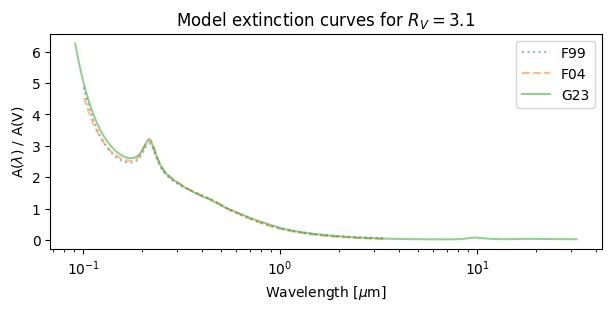

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron

### Select our target and get its known information

In [4]:
# search_term = target = "V* CW Eri"
# target_coords = SkyCoord(45.99980203 * u.deg, -17.73779498 * u.deg, 191.7 * u.pc, frame="icrs")

# k, k_err = 0.703448, 0.000605       # from LC fitting
# J, J_err = 0.929822, 0.002874       # from LC fitting

# # Known Teffs & masses from literature
# known_teff1 = 6839 # +/- 87
# known_teff2 = 5661 # +/- 98
# known_M1 = 1.568 # +/- 0.016
# known_M2 = 1.314 # +/- 0.010
# known_age = 9.23 # log10(1.7 Gyr)

In [5]:
# search_term = target = "V* ZZ UMa"
# target_coords = SkyCoord("10h30m03.1946894976", "+61d48m41.430038256", 180.2 * u.pc, frame="icrs")

# k, k_err = 0.747898, 0.031343       # from LC fitting
# J, J_err = 0.633319, 0.027377       # from LC fitting

# # Known Teffs and masses from literature
# known_teff1 = 5960 # +/- 70
# known_teff2 = 5270 # +/- 90
# known_M1 = 1.1348 # +/- 0.0087
# known_M2 = 0.9652 # +/- 0.0051
# known_age = 9.74 # log10(5.5 Gyr)

In [6]:
# search_term = target = "V* MU Cas"
# target_coords = SkyCoord("00h15m51.5603463336", "+60d25m53.642838468", 1948 * u.pc, frame="icrs")

# k, k_err = 0.864, 0.026             # from LC fitting
# J, J_err = 1.017, 0.013             # from LC fitting

# # Known Teffs and masses from Rediscussion 22
# known_teff1 = 14870 # +/- 500
# known_teff2 = 14940 # +/- 500
# known_M1 = 4.674    # +/- 0.091
# known_M2 = 4.586    # +/- 0.084
# known_age = 7.94    # log10(87 +/- 5 Myr)

In [7]:
# search_term = target = "V* RR Lyn"
# target_coords = SkyCoord("06h26m25.8366305040", "+56d17m06.346261104", 80.5 * u.pc, frame="icrs")

# k, k_err = 0.627, 0.002             # from LC fitting
# J, J_err = 0.818, 0.007             # from LC fitting

# # Known Teffs and masses from Rediscussion 7
# known_teff1 = 7770  # +/- 200
# known_teff2 = 7180  # +/- 200
# known_M1 = 1.939    # +/- 0.007
# known_M2 = 1.510    # +/- 0.003
# known_age = 8.98    # log(950 +/- 20 Myr)

In [8]:
search_term = target = "V* CM Dra"
target_coords = SkyCoord("16h34m20.3302660573", "+57d09m44.368918696", 14.844 * u.pc, frame="icrs")

k, k_err = 0.954, 0.015             # from LC fitting
J, J_err = 0.975, 0.017             # from LC fitting

# Known Teffs, masses and age from MartinSethi+24mnras
known_teff1 = 3130  # +/- 70
known_teff2 = 3120  # +/- 70
known_M1 = 0.2310   # +/- 0.0009
known_M2 = 0.2141   # +/- 0.0010
known_age = 9.9     # log(8.5 +/- 3.5 Gyr)

### Get the SED data for the target
- apply default uncertainties to those measurements with none
- exclude measurements outside the range of our extinction model
- exclude outliers

In [9]:
# Read in the SED for this target
sed_cache_dir = Path(".cache/.sed/")
sed_cache_dir.mkdir(parents=True, exist_ok=True)
sed_fname = sed_cache_dir / (re.sub(r"[^\w\d-]", "-", target.lower()) + ".vot")
if sed_fname.exists():
    sed = Table.read(sed_fname)
else:
    sed = Table.read(f"https://vizier.cds.unistra.fr/viz-bin/sed?-c={quote_plus(search_term)}&-c.rs=0.1")
    sed.write(sed_fname, format="votable") # votable matches that published in link above
sed.sort(["sed_freq"], reverse=True)

In [10]:
# Set flux uncertainties to 10% where none given
mask_no_err = (sed["sed_eflux"].value == 0) | np.isnan(sed["sed_eflux"])
sed["sed_eflux"][mask_no_err] = sed["sed_flux"][mask_no_err] / 10

# Get the data into SI units
sed["sed_flux"] = sed["sed_flux"].to(u.W / u.m**2 / u.Hz)
sed["sed_eflux"] = sed["sed_eflux"].to(u.W / u.m**2 / u.Hz)
sed["sed_freq"] = sed["sed_freq"].to(u.Hz)

# Add wavelength, and vF(v) columns which we'll need for plots
sed["sed_wl"] = np.divide(c * u.m / u.s, sed["sed_freq"]).to(u.um)
sed["sed_vfv"] = sed["sed_flux"] * sed["sed_freq"] * u.Hz   # Need explicit units to cancel the Hz
sed["sed_evfv"] = sed["sed_eflux"] * sed["sed_freq"] * u.Hz

In [11]:
# Filter SED to those covered by our models and also remove any outliers
model_mask = (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(ne_wl_range)) & (sed["sed_wl"] <= max(ne_wl_range))
out_mask = sed["sed_filter"] == "HIP:hp"    # These tend to give outliers at ~0.402 um
if "CW Eri" in target:
    out_mask |= sed["sed_filter"] == "Cousins:I"
sed = sed[model_mask & ~out_mask]

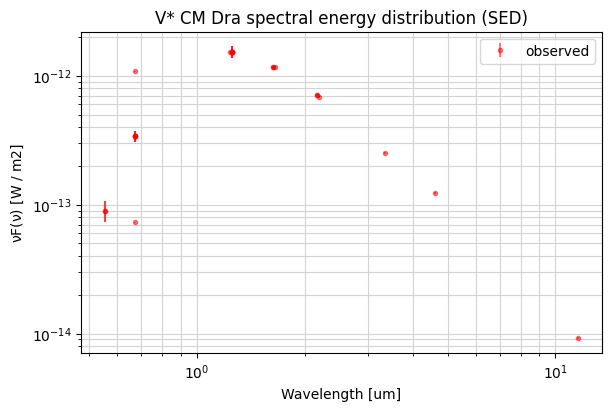

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed["sed_vfv"], sed["sed_evfv"], fmt=".r", alpha=0.5, label="observed")
ax.set(title=f"{target} spectral energy distribution (SED)",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_vfv'].unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### De-redden the SED

In [13]:
from requests.exceptions import HTTPError
try:
    # Creates/confirms local cache of Bayestar data within the .cache directory
    config.config['data_dir'] = '.cache/.dustmapsrc'
    bayestar.fetch(version="bayestar2019")
except HTTPError as exc:
    print(f"Unable to (re)fetch data. Caught error '{exc}'")
except ValueError as exc:
    print(f"Unable to parse response. Caught error '{exc}'")

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [14]:
query = bayestar.BayestarQuery(version='bayestar2019')
Ebv, _flags = query(target_coords, mode='median', return_flags=True)

# Relations from Bayestar 17 or 19 to E(B-V) documented at http://argonaut.skymaps.info/usage
# as E(B-V) = 0.884*bayestar or E(B-V) = 0.996*bayestar
Ebv *= 0.996
print(f'For {target} the {query.__class__.__name__} extinction is: E(B-V) = {Ebv:.6f} mag',
       '\n( diagnostic flags:', ', '.join(f'{n} = {_flags[n]}' for n in _flags.dtype.names), ')') 

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.374 s
  pix_info:   0.339 s
   samples:  14.481 s
      best:   2.782 s
       nan:   0.019 s
      sort:   7.670 s
       idx:   0.083 s
For V* CM Dra the BayestarQuery extinction is: E(B-V) = 0.000000 mag 
( diagnostic flags: converged = True, reliable_dist = False )


In [15]:
Av = None
if not Ebv:
    try:
        # Extinction map of Vergely, Lallement & Cox (2022)
        # TODO: anything extra to map these values to Av?
        ivoid = 'ivo://CDS.VizieR/J/A+A/664/A174'
        table = 'J/A+A/664/A174/cube_ext'
        vo_res = registry.search(ivoid=ivoid)[0]
        print(f'Querying {vo_res.res_title} ({vo_res.source_value}) for extinction data...')

        for _res in [10, 50]: # central regions at 10 pc resolution and outer at 50 pc
            _cart = np.round(target_coords.cartesian.xyz.to(u.pc) / _res) * _res
            _rec = vo_res.get_service('tap').search(f'SELECT * FROM "{table}" ' + 
                f'WHERE x={_cart[0].value:.0f} AND y={_cart[1].value:.0f} AND z={_cart[2].value:.0f}''')
            if len(_rec):
                ext_nmag_per_pc = _rec["Exti"][0]
                Av = (ext_nmag_per_pc * target_coords.distance.to(u.pc).value) / 10**9
                print(f"For {target} the nearest extinction value is: Av={Av:.6f}")
                break
    except DALServiceError as exc:
        print(f"Failed to query: {exc}")

Querying Galactic interstellar dust Gaia-2MASS 3D maps (2022A&A...664A.174V) for extinction data...
For V* CM Dra the nearest extinction value is: Av=0.001527


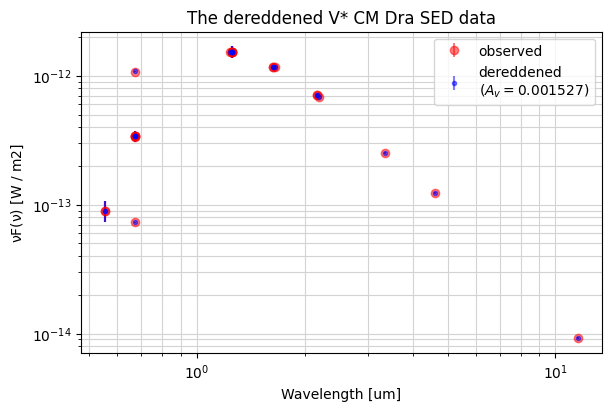

In [16]:
# extinguish calcs extinction as a factor, so dividing by it will de-redden
if Ebv: # Prefer the Ebv from Bayestar
    sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=Ebv)
    der_lab = f"dereddened\n(E(B-V)={Ebv:.6f})"
elif Av:
    sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Av=Av)
    der_lab = f"dereddened\n($A_v={Av:.6f}$)"
else:
    print(f"!!!No de-reddening found!!!")
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"
sed["sed_der_vfv"] = sed["sed_der_flux"] * sed["sed_freq"] * u.Hz

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed["sed_vfv"], sed["sed_evfv"], fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed["sed_wl"], sed["sed_der_vfv"], sed["sed_evfv"], fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"The dereddened {target} SED data",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_der_vfv'].unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Set up the MCMC functions

#### Model the combined spectrum based on NewEra stellar atmosphere models

In [17]:
def newera_model(x, Teff1, Teff2, logg1, logg2):
    def newera_spectrum(teff, logg):
        # Find the rows with the nearest Teff
        teff_best_diff = teff - ne_table["teff"][np.argmin(np.abs(ne_table["teff"] - teff))]
        teff_mask = (ne_table["teff"] + teff_best_diff == teff) \
                    | (ne_table["teff"] - teff_best_diff == teff)

        # And select the row with the nearest logg
        row = ne_table[teff_mask][np.argmin(np.abs(ne_table["logg"][teff_mask] - logg))]
        return row["flux_interp"](x)
    return ( newera_spectrum(Teff1, logg1), newera_spectrum(Teff2, logg2) )

#### The MCMC functions
- `lnlike` is the _likelihood function_ which compares the model spectra with the observed data (both normalized)
- `lnprior` contains any _prior knowledge_ we have about the parameters from elsewhere
  - in this case there are restrictions on stellar age/phase and a known ratio of radii from LC fitting
  - also returns a blob containing the two stars' $T_{\rm eff}$ and $\log{g}$ values for masses and age being sampled
- `lnprob` combines the two into a probability density

#### Prepare and run the MCMC

In [18]:
nwalkers = 100
niters = 100000

# Starting position for the search - known values rounded to nearest 0.5 for now
init_M1, init_M2 = max(0.1, round(known_M1*2)/2), max(0.1, round(known_M2*2)/2)
init_age = max(5.0, round(known_age*2)/2)
print(f"Starting point:\nM1 = {init_M1} M_sun\nM2 = {init_M2} M_sun\nlog(age) = {init_age}")

rng = np.random.default_rng(42)
initial = np.array([init_M1, init_M2, init_age])
ndim = len(initial)
p0 = [initial + rng.normal(0, 0.1, ndim) for _ in range(nwalkers)]


# Fitting will be based on a normalized copy of the dereddened fluxes
sed["sed_norm_flux"], sed["sed_norm_eflux"] = min_max_normalize(sed["sed_der_flux"].value,
                                                                sed["sed_eflux"].value)

# These are the "fixed" kwargs which will be sent to the MCMC ln_prob function
kwargs = {
    "x": sed["sed_freq"].value,
    "y": sed["sed_norm_flux"].value,
    "y_err": sed["sed_norm_eflux"].value,
    "k": k,
    "model_func": newera_model
}

Starting point:
M1 = 0.1 M_sun
M2 = 0.1 M_sun
log(age) = 10.0


In [19]:
with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for {niters} iterations...")
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=ln_prob, kwargs=kwargs, pool=pool)
        state = sampler.run_mcmc(p0, niters, progress=True)

Running MCMC for 100000 iterations...


100%|██████████| 100000/100000 [13:25<00:00, 124.08it/s]


In [20]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction: {accept_frac:.6f}")

try:
    # autocorrelation time; steps to effectively "forget" start position
    tau = sampler.get_autocorr_time()
    print(f"Autocorrelation steps:   ", ", ".join(f"{t:.3f}" for t in tau))
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau

Mean Acceptance fraction: 0.287326


/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


Autocorrelation steps:    nan, nan, nan


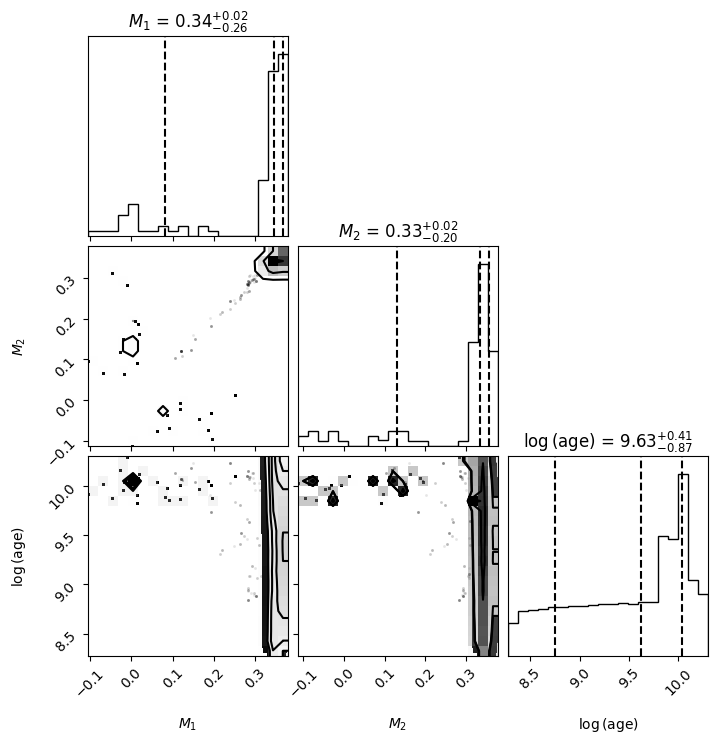

In [21]:
warm_discard = int(np.mean(np.nan_to_num(tau, copy=True, nan=1000))) * 2
thin = max(1, int(1 / (1-max(accept_frac, 0.1))))

# thin; every nth step from the chain
samples = sampler.get_chain(discard=warm_discard, thin=thin, flat=True)
labels = [r"$M_{\rm 1}$", r"$M_{\rm 2}$", r"$\log{({\rm age})}$"]
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])

In [22]:
# Gets the median fitted values (currently M1, M2 and log(age))
fitted_vals = np.median(samples, axis=0)
fitted_high = np.quantile(samples, 0.84, axis=0) - fitted_vals
fitted_low = fitted_vals - np.quantile(samples, 0.16, axis=0)

for ix, (var, known) in enumerate([("M1", known_M1), ("M2", known_M2), ("log(age)", known_age)]):
    print(f"{var:>9s} = {fitted_vals[ix]:.3f} +/- {fitted_high[ix]:.3f}/{fitted_low[ix]:.3f}",
          f"(known value {known:.3f})")

       M1 = 0.344 +/- 0.022/0.263 (known value 0.231)
       M2 = 0.333 +/- 0.024/0.202 (known value 0.214)
 log(age) = 9.626 +/- 0.413/0.872 (known value 9.900)


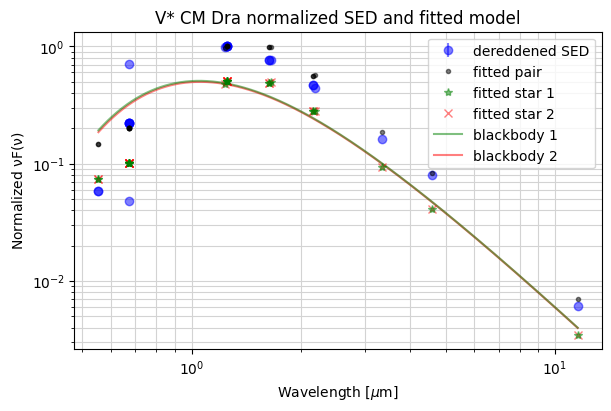

In [23]:
# Need to get the effective temperatures & logg for these masses/age combinations
M1, M2, log_age = fitted_vals
teff1, logg1 = mist_isos.stellar_params_for_mass(0, log_age, M1, ["Teff", "log_g"])
teff2, logg2 = mist_isos.stellar_params_for_mass(0, log_age, M2, ["Teff", "log_g"])

# Generate a model SED from the fitted values for plotting
sed_freq = sed["sed_freq"].value
mod_star_vfv = newera_model(sed_freq, teff1, teff2, logg1, logg2) * sed_freq
mod_comb_vfv = np.add(*newera_model(sed_freq, teff1, teff2, logg1, logg2)) * sed_freq
mod_norm_scale = mod_comb_vfv.max() - mod_comb_vfv.min()

# lambdas/freqs for getting fluxes and plotting contiguous lines (rather than points of sed_lambda)
cont_lambda = np.logspace(np.log10(sed["sed_wl"].min()), np.log10(sed["sed_wl"].max()), 1000)
cont_freq = c*1e6 / cont_lambda

# Set up BB model curves for comparison
bb_star_vfv = blackbody_model(cont_freq, teff1, teff2) * cont_freq
bb_comb_vfv = np.add(*blackbody_model(cont_freq, teff1, teff2)) * cont_freq
bb_norm_scale = bb_comb_vfv.max() - bb_comb_vfv.min()

# Get the dereddened observed SED data
sed_norm_scale = sed["sed_vfv"].max() - sed["sed_vfv"].min()

# Plot the fitted model against the derredened SED + show each star's contribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
for (lam,           flux,              eflux,           norm_scale,         fmt,    z,      label) in [
    (sed["sed_wl"], sed["sed_vfv"],    sed["sed_evfv"], sed_norm_scale,     "ob",   10,     "dereddened SED"),
    (sed["sed_wl"], mod_comb_vfv,      None,            mod_norm_scale,     ".k",   90,     "fitted pair"),
    (sed["sed_wl"], mod_star_vfv[0],   None,            mod_norm_scale,     "*g",   80,     "fitted star 1"),
    (sed["sed_wl"], mod_star_vfv[1],   None,            mod_norm_scale,     "xr",   70,     "fitted star 2"),
    (cont_lambda,   bb_star_vfv[0],    None,            bb_norm_scale,      "-g",   60,     "blackbody 1"),
    (cont_lambda,   bb_star_vfv[1],    None,            bb_norm_scale,      "-r",   50,     "blackbody 2"),
]:
    # Rather than (flux-min(flux))/norm_scale we plot flux/norm_scale so that we don't loose the lowest value to zero
    ax.errorbar(lam, (flux)/norm_scale, eflux, fmt=fmt, alpha=0.5, zorder=z, label=label)
ax.set(title=f"{target} normalized SED and fitted model",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$", xscale="log", yscale="log")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)